In [1]:
%matplotlib inline

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pdb
from tqdm.auto import tqdm
import multiprocessing as mp
from scipy.stats import norm as normal
import math

import matplotlib
import matplotlib.pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

from tqdm.auto import tqdm
import numpy as np

import torch
torch.manual_seed(123)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import pdb

from torchvision.datasets import MNIST

import itertools
import copy

from scipy.ndimage import gaussian_filter, uniform_filter
from scipy.ndimage.filters import convolve

import PIL
from PIL import Image

import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import time
from scipy.signal import savgol_filter

In [17]:
def smooth_expt(h, alpha=10, beta=10, plotAll=False, plotZero=False, border=-1):
    CVAL = 0
    
    # Obtain h * N_alpha
    h1 = gaussian_filter(h, sigma=alpha,mode='constant',cval=CVAL)

    # Obtain phi(h * N_alpha)
    h2 = copy.deepcopy(h1)
    h2[h2 < 0.5] = 0
    h2[h2 >= 0.5] = 1

    # Obtain phi(h * N_alpha) * N_beta
    h3 = gaussian_filter(h2, sigma=beta,mode='constant',cval=CVAL)

    # Obtain phi(phi(h * N_alpha) * N_beta)
    h4 = copy.deepcopy(h3)
    h4[h4 < 0.5] = 0
    h4[h4 >= 0.5] = 1

    phih = copy.deepcopy(h)
    phih[phih < 0.5] = 0
    phih[phih >= 0.5] = 1

    diff = phih - h4
    if border > 0:
        diff[:border, :] = 0
        diff[-border:, :] = 0
        diff[:, :border] = 0
        diff[:, -border:] = 0

    if plotAll:
        if plotZero:
            # phi(h) * N_beta
            h6 = gaussian_filter(copy.deepcopy(phih), sigma=beta, mode='constant',cval=CVAL)
            h7 = copy.deepcopy(h6)
            h7[h7 < 0.5] = 0
            h7[h7 >= 0.5] = 1
            plot_figure(h, h1, h2, h3, h4, diff, alpha, beta, plotZero=(h6, h7))
        else:
            plot_figure(h, h1, h2, h3, h4, diff, alpha, beta)
        
    return np.mean(np.abs(diff)), (h, h1, h2, h3, h4, diff, alpha, beta)

## Generate the Synthetic Distribution

In [ ]:
sidesz = 100
def sample_sphere_dist_nogrid(zeta, r=10, ret_c=False, side=1000, num_try=200):
    g = np.zeros((side, side))
    g_center = np.zeros((side, side))
    c = np.random.randint(low=0, high=side, size=[num_try, 2])
    
    lst = []
    sep = (2 * r + zeta)
    for (cx, cy) in c:
        if np.sum(g_center[int(max(0, cx-sep)):int(min(side, cx+sep)), int(max(0, cy-sep)):int(min(side, cy+sep))]) == 0:
            g_center[cx, cy] = 1
            lst.append((cx, cy))
            for dx in range(-r, r):
                for dy in range(-r, r):
                    if (dx) ** 2 + (dy) ** 2 <= r ** 2:
                        if (cx + dx < side and cy + dy < side):
                            g[cx + dx, cy + dy] = 1
                        
#         if np.sum(g * tempg) <= 0:    
#             lst.append((cx, cy))
#             g = g + tempg
    
    c = np.zeros(shape=[len(lst), 2])
    removed = [False for _ in range(len(lst))]
    
    for idx in range(len(lst)):
        c[idx, 0] = lst[idx][0]
        c[idx, 1] = lst[idx][1]
        
    if ret_c:
        return g, c, removed
    else:
        return g

<Figure size 432x288 with 0 Axes>

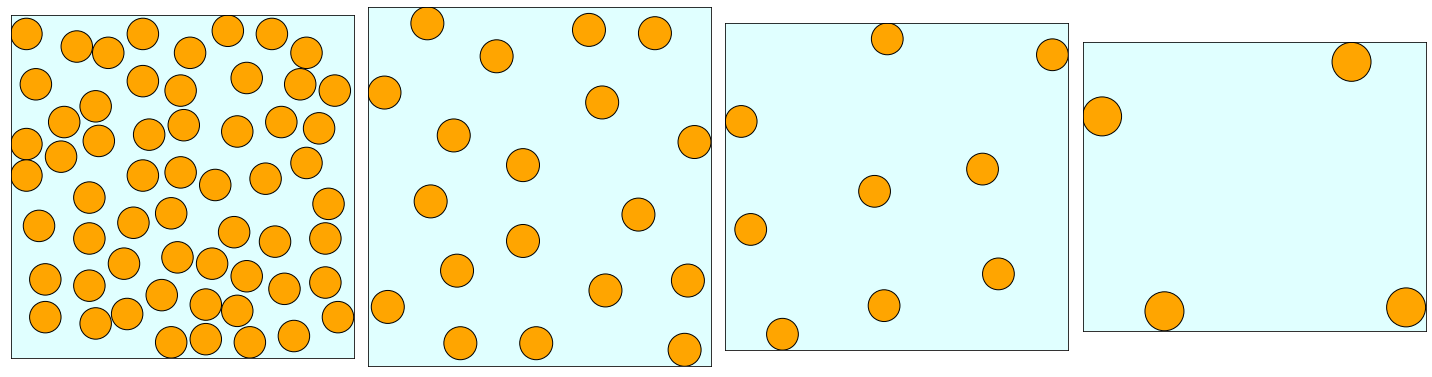

In [19]:
plt.clf()
plt.rc('axes', titlesize=14)
rad = 5
num = 10000
zeta_range_plot = [0, 10, 20, 30]
sidesz=100

ctr = 1
fig, axes = plt.subplots(nrows=1, ncols=len(zeta_range_plot), figsize=(20, 20))
for zeta in zeta_range_plot:
    ax = axes[ctr - 1]; ctr = ctr + 1
    g_temp, c_temp, removed_temp = sample_sphere_dist_nogrid(zeta, rad, ret_c=True, num_try=num, side=sidesz)

    patches = []
    for i in range(c_temp.shape[0]):
        if not removed_temp[i]:
            center = (c_temp[i, 0], c_temp[i, 1])
            circle = mpatches.Circle(center, radius=rad)
            patches.append(circle)

    collection = PatchCollection(patches, color='orange', ec='black', linestyle='-')
    ax.add_collection(collection)

    ax.use_sticky_edges = False
    ax.margins(x=0, y=0)
    ax.set_aspect('equal')
    ax.set_facecolor('lightcyan')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

plt.tight_layout()
plt.show()
plt.close('all')

### Generate Curves in Fig. 4. using the Synthetic Distribution above

In [25]:
zeta_range = [0, 1, 2, 3] #range(0, 5)
beta_range = [8.0, 11.0, 14.0]
alpha_range = np.linspace(0, 20, 21)#range(0, 5)#np.linspace(0, 25, 13)
sidesz = 100
rad = 10

print ('side', sidesz)
print ('rad', rad)
print ('zeta_range', zeta_range)
print ('beta_range', beta_range)
print ('alpha_range', alpha_range)
print ('num_try', num)

side 100
rad 10
zeta_range [0, 1, 2, 3]
beta_range [8.0, 11.0, 14.0]
alpha_range [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
num_try 10000


246


<Figure size 432x288 with 0 Axes>

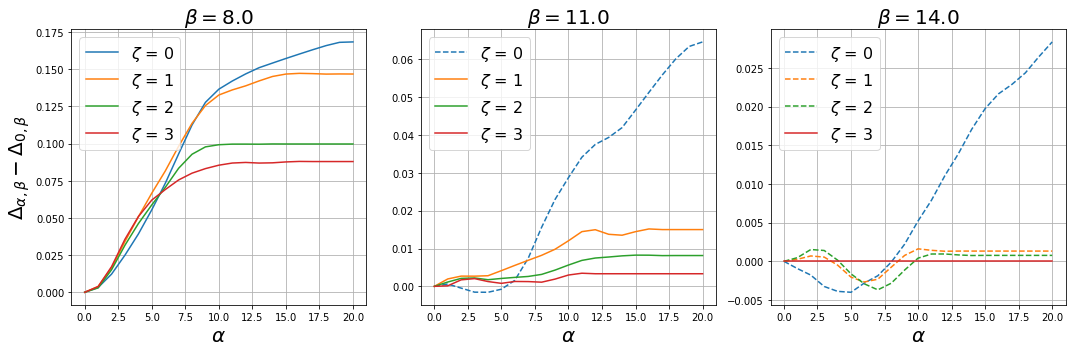

In [32]:
random_seed = 246
print (random_seed)
np.random.seed(random_seed)

plots = {}
for beta in tqdm(beta_range):
    for zeta in zeta_range:
        diffs_arr = []

        for sample in range(10):
            g = np.array(sample_sphere_dist_nogrid(zeta, rad, num_try=num, side=sidesz), dtype=np.float32)

            diffs = []
            for alpha in alpha_range:
                diff_norm, (h, h1, h2, h3, h4, diff, _,_) = smooth_expt(g, alpha, beta, plotAll=False, border=0)
                diffs.append(diff_norm)

            baseline = diffs[0]
            mod_diffs = [item - baseline for item in diffs]
            diffs_arr.append(mod_diffs)


        plots[(beta, zeta)] = np.mean(np.array(diffs_arr, dtype=np.float32), axis=0)

plt.clf()
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
plt.rc('legend', fontsize=16)

# plt_side = int(np.sqrt(len(beta_range))) + 1
plt.figure(figsize=(3 * 5, 1 * 5), tight_layout=True)
plt.autoscale(tight=True)
plt.margins(x=0.05, y=0.05)

ctr = 1

beta_range_plot = [8.0, 11.0, 14.0] #beta_range
alpha_range_len = len(alpha_range)
zeta_range_plot = [0, 1, 2, 3] #zeta_range

for beta in tqdm(beta_range_plot):
    plt.subplot(1, 3, ctr); ctr = ctr + 1
    if ctr == 2: plt.ylabel(r'$\Delta_{\alpha, \beta} - \Delta_{0, \beta}$')
    for zeta in zeta_range_plot:
        ymod = plots[(beta, zeta)][:alpha_range_len]
        ymod = savgol_filter(ymod, 5, 3)
        ymod = [item - ymod[0] for item in ymod]

        if np.min(plots[(beta, zeta)][:alpha_range_len]) < 0: linestyle='dashed'
        else: linestyle='solid'

        plt.plot(alpha_range[:alpha_range_len], ymod, label='$\zeta$ = {}'.format(zeta), ls=linestyle)#, marker='o',)
    plt.title('$\\beta={}$'.format(beta))
    plt.xlabel(r'$\alpha$')
    plt.legend(loc='upper left')
    plt.grid()

fig = plt.gcf()
plt.show()